# Entropic Braiding Index
Calculating the eBI and BI ratios from Tejedor et al., 2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
# from shapely.geometry import Polygon, MultiPolygon
import seaborn as sns
from scipy import stats

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

In [3]:
### Load data

path = '/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/fullbed-interp/'
depth = np.load(f'{path}depth.npy', allow_pickle = True)
velo = np.load(f'{path}velocity.npy', allow_pickle = True)
ylocs = np.load(f'{path}ypos.npy', allow_pickle = True)
xlocs = np.load(f'{path}xpos.npy', allow_pickle = True)
bedz = np.load(f'{path}bed_elevation.npy', allow_pickle = True)
watersurf = np.load(f'{path}watersurf.npy', allow_pickle = True)

In [4]:
cellq = np.multiply(depth, velo)

In [25]:
section_sampling = 1
secstart = 100
secend = 900
adjustment_time = 65
seclist = np.arange(secstart, secend+1, section_sampling)
threshold = 0.25

In [26]:
seclist = np.insert(seclist, 10, [340, 370])

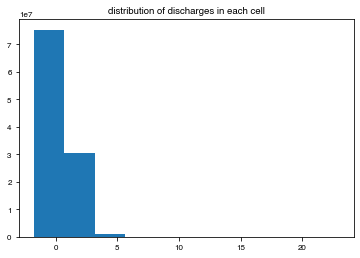

In [27]:
plt.hist(cellq.ravel());
plt.title('distribution of discharges in each cell');

In [28]:
q_sample = cellq[:, seclist, adjustment_time:] ## get discharges at all of the sample locations

In [29]:
q_sample[q_sample<threshold] = np.nan ##make nans where discharge is less than threshold values
print(q_sample.shape)

(705, 803, 317)


In [30]:
startt = adjustment_time
endt = cellq.shape[2]+1

In [32]:
def ebicalc(watermask):
    '''return the ebi of every xs position in an array of [water, not water]
    rows = cross stream position
    columns = x locations
    z = timesteps where watermask is an array of data on thechannel, previous versions have used width, here I use cellular discharge'''
    
    ebi = np.empty([1, watermask.shape[1], watermask.shape[2]])## create a storage matrix for ebi data values
    ww = np.empty([1, watermask.shape[1], watermask.shape[2]])## create a storage matrix for ebi data values
    ebi[:, :, :] = np.nan
    print(ebi.shape)
    ### current way I can think of doing this is taking each cross section, finding all the thread edges using l_edge, r_edge 
    ### code from polygon diagrams and getting those widths and using width as a Q proxy to get ebi.
    
    for ts in range(watermask.shape[2]): ##adjustment time already removed from array
#     for ts in range(startt, endt):
        for xpos in range(watermask.shape[1]):
#             print('xpos, ts', xpos, ts)
            l_idx = np.array([])
            r_idx = np.array([])
            threadq_list = np.array([])
            for ypos in range(watermask.shape[0]-1):
                # l_edge = np.logical_and(np.isnan(watermask[ypos, xpos, ts]), ~np.isnan(watermask[ypos, xpos, ts]))
                # r_edge = np.logical_and(~np.isnan(watermask[ypos, xpos, ts]), np.isnan(watermask[ypos:, xpos, ts]))
                
                l_edge = np.all(np.isnan(watermask[ypos, xpos, ts]) and ~np.isnan(watermask[ypos+1, xpos, ts]))
                r_edge = np.all(~np.isnan(watermask[ypos, xpos, ts]) and np.isnan(watermask[ypos+1, xpos, ts]))
#                 print(ypos, xpos, ts, l_edge, r_edge) ## yes this works.
                if l_edge == True:
                    l_idx = np.append(l_idx, [ypos], axis = 0)

                if r_edge == True:
                    r_idx = np.append(r_idx, [ypos], axis = 0)
            l_idx = l_idx.astype('int')
            r_idx = r_idx.astype('int')
            for tl, tr in zip(l_idx, r_idx): ##for each left and right edge of thread
                threadq = np.nansum(watermask[tl:tr+1, xpos, ts]) ## find the discharge of the thread
                threadq_list = np.append(threadq_list, [threadq], axis = 0) ## create a list of the thread widths at each position, this will not be output
#             print(xpos, len(threadq_list))
            xs_discharge = np.nansum(threadq_list) ##find the discharge across the section
            
            ebi[:, xpos, ts] = -1* np.nansum((threadq_list/xs_discharge)*np.log2(threadq_list/xs_discharge))
            ww[:, xpos, ts] = len(threadq_list)
#             if len(threadq_list<2):
#                 print(ts, xpos)
#             print(xpos, len(threadq_list))
        #             print(ebi[:, xpos, ts])
#             if xpos == 5:
#                 print(threadq_list, xs_discharge)
#     print(ebi.shape)
    ebi = 2**ebi
    return ebi, ww

In [33]:
# ylocs_nan[200:300, 0, 0]
ebi_3d, wetwtd = ebicalc(q_sample) ## this is actually not wetted width its the braided index or thread count, idk why I called it wet wt thats counter intuitive but I wont change it bc I don ant to break anything

(1, 803, 317)


KeyboardInterrupt: 

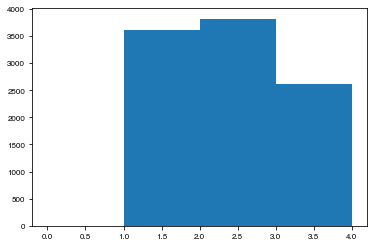

In [16]:
plt.hist(ebi_3d.ravel(), bins = np.arange(0, 5, 1));

In [17]:
ebi2d = np.transpose(copy.deepcopy(ebi_3d)) ## entropic briading index
wetwd2d = np.transpose(copy.deepcopy(wetwtd)) #braiding index

In [18]:
ebi2d[:, :, 0]

array([[2.20984975, 2.79292509, 1.99831341, ..., 1.13066526, 2.6371319 ,
        1.81702248],
       [2.10706716, 2.67439253, 1.92498139, ..., 1.        , 2.11041685,
        3.27990266],
       [2.37098916, 2.63644167, 1.81012315, ..., 1.        , 1.87346433,
        2.77793996],
       ...,
       [3.22906344, 5.19970312, 1.23852776, ..., 1.74082052, 2.76003207,
        1.80528076],
       [3.31192958, 5.4215448 , 2.68388283, ..., 3.0914275 , 3.55594018,
        1.54407673],
       [3.57653654, 3.73504652, 1.1797729 , ..., 3.13288774, 2.80006214,
        1.2985686 ]])

In [19]:
ebidf = pd.DataFrame(copy.deepcopy(ebi2d[:, :, 0]), columns = seclist)
wetwtdf = pd.DataFrame(copy.deepcopy(wetwd2d[:, :, 0]), columns = seclist)

Text(0, 0.5, 'BI/eBI')

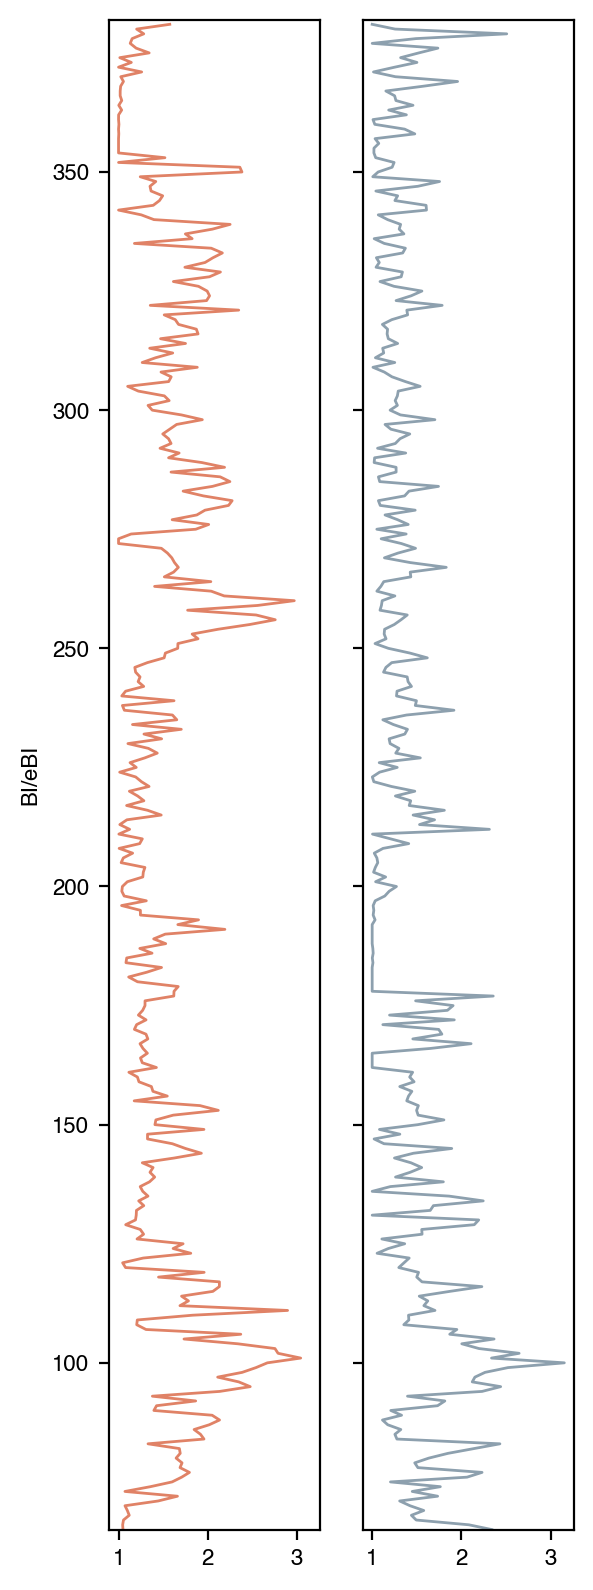

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (3, 10), dpi = 200, sharey = True, sharex = True)
ax[0].plot(wetwtdf[340]/ebidf[340], np.arange(startt, endt-1), ms = 5, c = '#e08266', lw = 1)
# ax[1].plot(wetwtdf[340], np.arange(startt, endt-1), ms = 5, c = '#e08266')

ax[1].plot(wetwtdf[370]/ebidf[370], np.arange(startt, endt-1), ms = 5, c = '#8da0ae', lw = 1)
# ax[3].scatter(ebidf[370], np.arange(startt, endt-1), s = 5, c = '#8da0ae')

ax[0].set_ylim(startt, endt-1)

ax[0].set_ylabel('BI/eBI')

Text(0.5, 0, 'Streamwise distance, x10m')

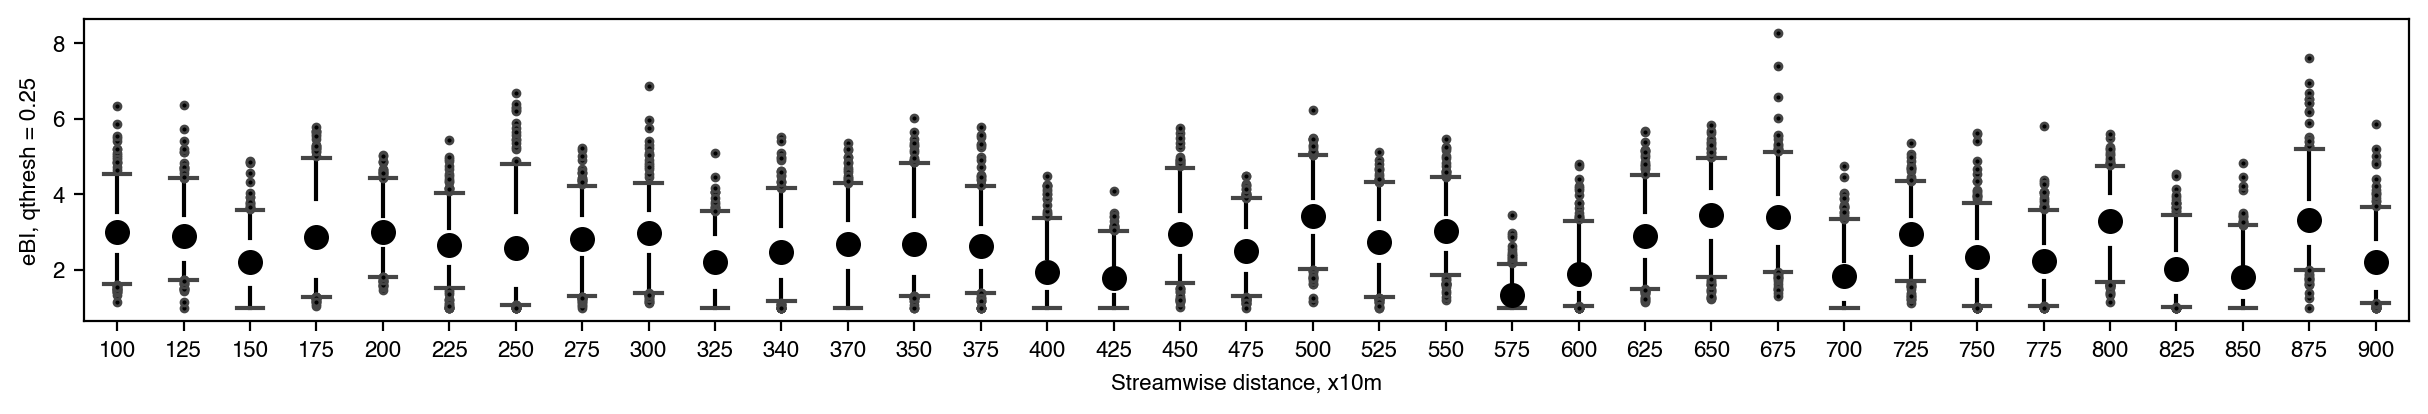

In [23]:
plt.figure(figsize = (15,2), dpi = 200)
PROPS = {'boxprops':{'facecolor':'none', 'edgecolor':'black', 'linewidth': 0}, 
         'whiskerprops':{'color':'k'}, 
        'flierprops':{'markerfacecolor':'k', 'marker':'.'}, 
        'medianprops':{'linewidth':0}}
sns.boxplot(data = ebidf, **PROPS, showmeans = True, whis=[5, 95], meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black", "markersize":"8"})

plt.ylabel(f'eBI, qthresh = {threshold}')
plt.xlabel('Streamwise distance, x10m')
# plt.savefig(f'/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/eBI{threshold}.png', dpi = 300, transparent = True)

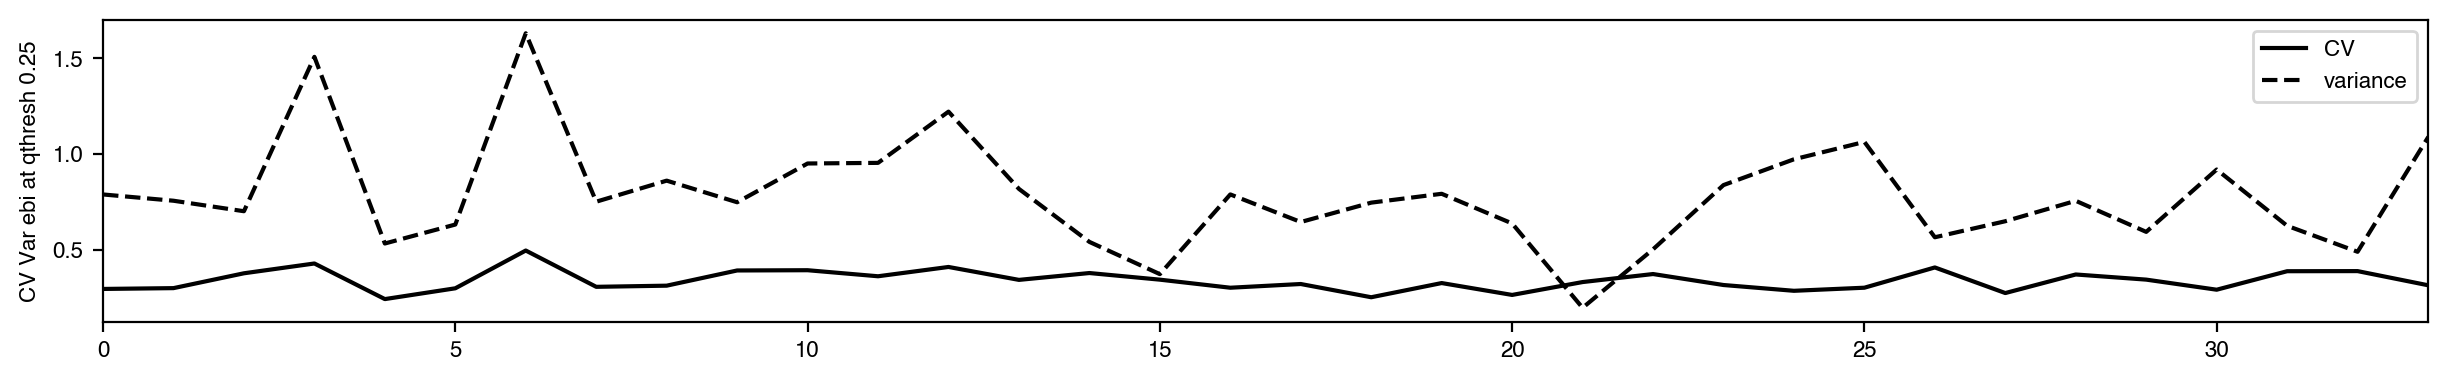

In [24]:
plt.figure(figsize = (15, 2), dpi = 200)
plt.plot(stats.variation(ebi2d, axis = 0), 'k', label = 'CV')
plt.plot(np.var(ebi2d, axis = 0), 'k--', label = 'variance')
plt.legend()
plt.xlim(0, 33)
plt.ylabel(f'CV Var ebi at qthresh {threshold}')
plt.savefig(f'/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/eBI_CVVar{threshold}.png', dpi = 300, transparent = True)